First, install dependencies and download the data

In [121]:
#%pip install -r requirements.txt
#!curl -l -o data.csv "https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+opa_properties_public&filename=opa_properties_public&format=csv&skipfields=cartodb_id"

In [122]:
import pandas as pd
import numpy as np

In [123]:
df = pd.read_csv('data.csv')

/tmp/ipykernel_91319/1507164070.py:1: DtypeWarning: Columns (5,13,22,26,31,54,55,68,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


In [124]:
df.shape

(582937, 82)

In [125]:
df.head()

,the_geom,the_geom_webmercator,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,lat,lng
0,0101000020E6100000288FB7AD4BC452C0C6E4F1E75A01...,0101000020110F00002693FA5D94E05FC1EE7D5D356691...,2022-05-24,NaN,120' NW EADOM ST,987458.0,RB,NON PD PKG LOT COMMERCIAL,6,VACANT LAND,...,NaN,NaN,19137.0,IRMX,1001189957,NaN,NaN,433143301,40.010587,-75.067119
1,0101000020E610000015F6916732CB52C0D4B37C0242FE...,0101000020110F0000F30438544DEC5FC1AAE24928F78D...,2022-05-24,NaN,273' N OF NORRIS ST,NaN,SR,VACANT LAND RESIDE < ACRE,6,VACANT LAND,...,NaN,NaN,19121.0,RSA5,1001505175,NaN,NaN,433143302,39.986389,-75.174951
2,0101000020E610000066AC299B48CA52C053CA1DF46CFD...,0101000020110F00004ACDE132C0EA5FC17F6F06010B8D...,2022-05-24,NaN,"263' 8"" N COLUMBIA AVE",NaN,U50,ROW CONV/APT 3 STY MASON,2,MULTI FAMILY,...,1890.0,NaN,19121.0,RM1,1001622123,22,ROW TYPICAL,433143303,39.979887,-75.160682
3,0101000020E6100000000000000000F87F000000000000...,NaN,2022-05-24,NaN,"1,115.962' S PATTISON AVE",NaN,SS,VACANT LAND RESIDE ACRE+,6,VACANT LAND,...,NaN,NaN,NaN,NaN,1001319180,NaN,NaN,433143304,NaN,NaN
4,0101000020E61000000C5CFE385BC452C0E38B05E75601...,0101000020110F0000F7332EC5AEE05FC1240EE0C46191...,2022-05-24,NaN,NEC SCATTERGOOD TO,NaN,RB,NON PD PKG LOT COMMERCIAL,6,VACANT LAND,...,NaN,NaN,19137.0,IRMX,1001189938,NaN,NaN,433143305,40.010465,-75.068068


In [126]:
df.columns

Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', 'owner_2', 'parcel_number', 'parcel_shape',
       'quality_grade', 'recording_d

Here we can see all of the columns available in the dataset. Many of these columns are not really necesary. For example, geographical data such as street addresses are not very useful because they don't contain any categorical or numerical data that can be easily consumed by a linear regression mode.

In [127]:
COLUMNS_TO_REMOVE = """
the_geom
the_geom_webmercator
beginning_point
book_and_page
building_code_description
category_code_description
cross_reference
geographic_ward
house_number
location
mailing_address_1
mailing_address_2
mailing_care_of
mailing_city_state
mailing_street
mailing_zip
other_building
owner_1
owner_2
parcel_number
registry_number
state_code
street_code
street_designation
street_direction
street_name
suffix
assessment_date
recording_date
sale_date
pin
zip_code
parcel_shape
quality_grade
building_code
building_code_new
building_code_description_new
objectid
unit
"""
df_first_column_drop = df.drop(columns=COLUMNS_TO_REMOVE.split())

Throughout this notebook, I will be periodically exporting the current dataframe to a CSV file. This is useful because I can then open the CSV file in an external program to check various aspects of the data throughout the development of the program.

In [128]:
# df_first_column_drop.to_csv('data_first_clean.csv', index=False)

One thing to note about this dataset is that this data is for all types of properties in Philadelphia. Since we are only interested in housing data, we will filter this data to only be for housing type properties. This is accomplished by filtering for properties with a category code of 1 (single family), or 2 (multi family)

In [129]:
# Get all unique values of (category_code, category_code_description)
df[['category_code', 'category_code_description']].drop_duplicates().sort_values(by='category_code')

,category_code,category_code_description
11,1,SINGLE FAMILY
72657,1,Single Family
2,2,MULTI FAMILY
103077,2,Multi Family
6,3,MIXED USE
103887,3,Mixed Use
5,4,COMMERCIAL
103634,4,Commercial
105777,5,Industrial
248,5,INDUSTRIAL


In [130]:
# Print number of data points
print(df_first_column_drop.shape)
# Filter category-type to 1, or 2
df_first_column_drop = df_first_column_drop[df_first_column_drop['category_code'] <= 2]
# Print number of data points
print(df_first_column_drop.shape)

(582937, 43)
(503907, 43)


Now that we have removed some of the columns, lets see what we are left with.

In [131]:
df_first_column_drop.dtypes

basements                   object
category_code                int64
census_tract               float64
central_air                 object
date_exterior_condition     object
depth                      float64
exempt_building            float64
exempt_land                float64
exterior_condition         float64
fireplaces                 float64
frontage                   float64
fuel                        object
garage_spaces              float64
garage_type                 object
general_construction        object
homestead_exemption          int64
house_extension             object
interior_condition         float64
market_value               float64
market_value_date          float64
number_of_bathrooms        float64
number_of_bedrooms         float64
number_of_rooms            float64
number_stories             float64
off_street_open            float64
sale_price                 float64
separate_utilities          object
sewer                       object
site_type           

We still have a lot of columns. It is very likely that many more of these will get dropped for the following reasons:
1. Too many missing values
2. Too many unique values
3. Not enough correlation with the target variable

Let's start by dealing with the first case: too many missing values. We will check this by counting the number of missing values in each column and sorting by this number.

There are also a few columns that seem to have a default value put in them instead of being left blank. Lets also change these default values to na, so they can be counted correctly.

In [132]:
df_first_column_drop['depth'] = df_first_column_drop['depth'].replace(0, np.nan)
df_first_column_drop['total_area'] = df_first_column_drop['total_area'].replace(0, np.nan)
df_first_column_drop['total_livable_area'] = df_first_column_drop['total_livable_area'].replace(0, np.nan)
df_first_column_drop['year_built'] = df_first_column_drop['year_built'].replace(0, np.nan)
df_first_column_drop['sale_price'] = df_first_column_drop['sale_price'].replace(1, np.nan)

In [133]:
# Print the number of missing values and the percentage of missing values
missing_values = df_first_column_drop.isna().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values = pd.DataFrame(missing_values, columns=['missing_values'])
missing_values['percentage_missing'] = missing_values['missing_values'] / len(df_first_column_drop)
print(missing_values)

                         missing_values  percentage_missing
market_value_date                503907            1.000000
unfinished                       503844            0.999875
utility                          503772            0.999732
site_type                        501863            0.995944
date_exterior_condition          501462            0.995148
sewer                            490034            0.972469
number_of_rooms                  489868            0.972140
house_extension                  489308            0.971028
separate_utilities               488822            0.970064
garage_type                      481716            0.955962
fuel                             456444            0.905810
central_air                      211179            0.419083
type_heater                      203555            0.403954
basements                        174364            0.346024
sale_price                       131445            0.260852
year_built_estimate               94314 

Now some of these pieces of missing data won't be that big of a deal because we can either fill or impute the data. We can also drop rows with missing data, but we should do this sparingly. For some categorical columns, you could set a default value, but I will not be doing this much. You cannot assume exactly what the person who entered the data intended by leaving it blank, and filling it could cause innacuracies, especially with columns with a lot of missing data. But for some columns, there is simply too much missing data. For this reason, I will be dropping all columns with more than 25% missing data.

In [134]:
COLUMNS_TO_REMOVE_MISSING_VALUES = missing_values[missing_values['percentage_missing'] > 0.25].index
df_second_column_drop = df_first_column_drop.drop(columns=COLUMNS_TO_REMOVE_MISSING_VALUES)

In [135]:
# df_second_column_drop.to_csv('data_second_clean.csv', index=False)

Now let's recheck the list of columns with missing data, and address each one indiviually.

In [136]:
missing_values_2 = df_second_column_drop.isna().sum().sort_values(ascending=False)
missing_values_2 = missing_values_2[missing_values_2 > 0]
missing_values_2 = pd.DataFrame(missing_values_2, columns=['missing_values'])
missing_values_2['percentage_missing'] = missing_values_2['missing_values'] / len(df_second_column_drop)
print(missing_values_2)

                      missing_values  percentage_missing
year_built_estimate            94314            0.187165
depth                          34709            0.068880
total_area                     32821            0.065133
topography                     32339            0.064177
general_construction           15954            0.031661
garage_spaces                   8248            0.016368
fireplaces                      6963            0.013818
number_of_bathrooms             6665            0.013227
off_street_open                 4751            0.009428
number_of_bedrooms              3458            0.006862
interior_condition              3339            0.006626
number_stories                  3323            0.006594
exterior_condition              3238            0.006426
frontage                        3149            0.006249
view_type                       2857            0.005670
zoning                          1177            0.002336
total_livable_area             

Now that we are left with columns with most of their data filled in, it is much safter to start filling in with default or imputed data.

In [137]:
from sklearn.impute import SimpleImputer
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')
df_fill = df_second_column_drop
# year_built_estimate can be filled with N's
df_fill['year_built_estimate'] = df_fill['year_built_estimate'].fillna('N')
# garage_spaces can just be filled with 0. It is a fair assumption that if the value is missing, there is no garage
df_fill['garage_spaces'] = df_fill['garage_spaces'].fillna(0)
# fireplaces can just be filled with 0. It is a fair assumption that if the value is missing, there are no fireplaces
df_fill['fireplaces'] = df_fill['fireplaces'].fillna(0)
# number of bathrooms can be filled with the median
df_fill['number_of_bathrooms'] = median_imputer.fit_transform(df_fill[['number_of_bathrooms']])
# interior condition can be filled with the median
df_fill['interior_condition'] = median_imputer.fit_transform(df_fill[['interior_condition']])
# exterior condition can be filled with the median
df_fill['exterior_condition'] = median_imputer.fit_transform(df_fill[['exterior_condition']])
# number of bedrooms can be filled with the median
df_fill['number_of_bedrooms'] = median_imputer.fit_transform(df_fill[['number_of_bedrooms']])
# number of stories can be filled with the median
df_fill['number_stories'] = median_imputer.fit_transform(df_fill[['number_stories']])
# general construction can be filled with a new category called 'unknown'
df_fill['general_construction'] = df_fill['general_construction'].fillna('unknown')
# quality grade will be skipped for now because it needs to be transformed into a numeric column
# year built can be filled with the median
df_fill['year_built'] = median_imputer.fit_transform(df_fill[['year_built']])
# total livable area can be filled with the median
df_fill['total_livable_area'] = median_imputer.fit_transform(df_fill[['total_livable_area']])
# topography can be filled with a new category called 'unknown'
df_fill['topography'] = df_fill['topography'].fillna('unknown')
# depth can be filled with the median
df_fill['depth'] = median_imputer.fit_transform(df_fill[['depth']])
# total area can be filled with the median
df_fill['total_area'] = median_imputer.fit_transform(df_fill[['total_area']])
# view type can be filled with a new category called 'unknown'
df_fill['view_type'] = df_fill['view_type'].fillna('unknown')
# off street open can be filled with the median
df_fill['off_street_open'] = median_imputer.fit_transform(df_fill[['off_street_open']])
# frontage can be filled with the median
df_fill['frontage'] = median_imputer.fit_transform(df_fill[['frontage']])
# zoning can be filled with a new category called 'unknown'
df_fill['zoning'] = df_fill['zoning'].fillna('unknown')
# census tract can be filled with the median
df_fill['census_tract'] = median_imputer.fit_transform(df_fill[['census_tract']])
# lat and lng can be filled with the median
df_fill['lat'] = median_imputer.fit_transform(df_fill[['lat']])
df_fill['lng'] = median_imputer.fit_transform(df_fill[['lng']])
# taxable building can be filled with the median
df_fill['taxable_building'] = median_imputer.fit_transform(df_fill[['taxable_building']])
# exempt land can be filled with the median
df_fill['exempt_land'] = median_imputer.fit_transform(df_fill[['exempt_land']])
# exempt building can be filled with the median
df_fill['exempt_building'] = median_imputer.fit_transform(df_fill[['exempt_building']])
# taxable land can be filled with the median
df_fill['taxable_land'] = median_imputer.fit_transform(df_fill[['taxable_land']])
# market value can be filled with the median
df_fill['market_value'] = median_imputer.fit_transform(df_fill[['market_value']])

Lets check again our missing data

In [138]:
missing_values_3 = df_fill.isna().sum().sort_values(ascending=False)
missing_values_3 = missing_values_3[missing_values_3 > 0]
missing_values_3 = pd.DataFrame(missing_values_3, columns=['missing_values'])
missing_values_3['percentage_missing'] = missing_values_3['missing_values'] / len(df_second_column_drop)
print(missing_values_3)

Empty DataFrame
Columns: [missing_values, percentage_missing]
Index: []


In [139]:
# df_fill.to_csv('data_filled.csv', index=False)

The next step is to encode the categorical data. There are 2 types of categorical data in our dataset: Boolean data, and multi-category. For the boolean data, we will convert the values into a binary number. For the multi-category data, we will one-hot encode them with the `pd.get_dummies()` function.

In [140]:
# One hot columns
ONE_HOT_COLUMNS = [
    'category_code',
    'general_construction',
    'topography',
    'view_type',
    'zoning',
]

BINARY_COLUMNS = [
    'year_built_estimate',
    'homestead_exemption',
    'exempt_building',
    'exempt_land'
]

In [141]:
# One hot encode the columns
df_one_hot = pd.get_dummies(df_fill, columns=ONE_HOT_COLUMNS)
# Binary encode the columns
df_one_hot['year_built_estimate'] = df_one_hot['year_built_estimate'].map({'Y': True, 'N': False})
# Fillna with False
df_one_hot['year_built_estimate'] = df_one_hot['year_built_estimate'].fillna(False)
df_one_hot['homestead_exemption'] = df_one_hot['homestead_exemption'].map({80000: True, 0: False})
# Fillna with False
df_one_hot['homestead_exemption'] = df_one_hot['homestead_exemption'].fillna(False)
# Exempt building should be false if 0, else true
df_one_hot['exempt_building'] = df_one_hot['exempt_building'].map({0: False})
# Fillna with True
df_one_hot['exempt_building'] = df_one_hot['exempt_building'].fillna(True)
# Exempt land should be false if 0, else true
df_one_hot['exempt_land'] = df_one_hot['exempt_land'].map({0.0: False})
# Fillna with True
df_one_hot['exempt_land'] = df_one_hot['exempt_land'].fillna(True)

/tmp/ipykernel_91319/4010469351.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_one_hot['year_built_estimate'] = df_one_hot['year_built_estimate'].fillna(False)
/tmp/ipykernel_91319/4010469351.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_one_hot['homestead_exemption'] = df_one_hot['homestead_exemption'].fillna(False)
/tmp/ipykernel_91319/4010469351.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to 

In [142]:
# Check that all columns are numeric
df_one_hot.dtypes.value_counts()

bool       78
float64    19
Name: count, dtype: int64

In [143]:
# Get columns with type bool
bool_columns = df_one_hot.select_dtypes(include=bool).columns
# Change type of columns to int (0 or 1)
df_one_hot[bool_columns] = df_one_hot[bool_columns].astype(int)

Now we have to remove outliers. This was accomplished by opening the dataset in the VSC data wrangler plugin to view the distributions of the columns and find any clear outliers. I then set a threshold for each column and removed any rows that had a value outside of this threshold.

In [144]:
# Delete outliers
df_outliers = df_one_hot
df_outliers = df_outliers[df_outliers['depth'] < 144]
df_outliers = df_outliers[df_outliers['depth'] > 32]
df_outliers = df_outliers[df_outliers['fireplaces'] < 6]
df_outliers = df_outliers[df_outliers['frontage'] < 50]
df_outliers = df_outliers[df_outliers['garage_spaces'] < 5]
df_outliers = df_outliers[df_outliers['market_value'] < 2_000_000]
df_outliers = df_outliers[df_outliers['number_of_bathrooms'] < 6]
df_outliers = df_outliers[df_outliers['number_of_bedrooms'] < 6]
df_outliers = df_outliers[df_outliers['number_stories'] < 6]
df_outliers = df_outliers[df_outliers['taxable_building'] < 1_000_000]
df_outliers = df_outliers[df_outliers['taxable_land'] < 200_000]
df_outliers = df_outliers[df_outliers['total_area'] < 16_000]
df_outliers = df_outliers[df_outliers['total_livable_area'] < 8_000]
df_outliers = df_outliers[df_outliers['year_built'] > 1890]

In [145]:
# Export to CSV excluding columns starting with ONE_HOT_COLUMNS
df_out = df_outliers
for column in ONE_HOT_COLUMNS:
    df_out = df_out.loc[:, ~df_out.columns.str.startswith(column)]
# df_out.to_csv('data_outliers.csv', index=False)

#df_outliers.to_csv('data_outliers.csv', index=False)
df_out.shape

(445963, 23)

In [171]:
# Create a new column called "bed+bath" which is the sum of the number of bedrooms and bathrooms
df_engineered = df_outliers
df_engineered['bed+bath'] = df_engineered['number_of_bedrooms'] + df_engineered['number_of_bathrooms']

In [172]:
# Create a correlation graphic agains the market value
correlation = df_engineered.corr()
# Print the correlation with the target variable
correlation['market_value'].sort_values(ascending=False)

market_value          1.000000
taxable_land          0.937928
taxable_building      0.765416
total_livable_area    0.517348
year_built            0.340224
                        ...   
interior_condition   -0.456576
zoning_ICMX|SPPOA          NaN
zoning_RSA5|RSA5           NaN
zoning_RSD1|RSD3           NaN
zoning_SPCIV               NaN
Name: market_value, Length: 98, dtype: float64

In [173]:
# Drop all columns with an absolute correlation less than 0.15
mv_correlations = correlation["market_value"]
#mv_correlations = mv_correlations[abs(mv_correlations) > 0.15]
df_engineered = df_engineered[mv_correlations.index]

Now that preprocessing is complete, we can move on to feature engineering. For this step we will be applying PCA to the data. With PCA, we will be having it reduce the dimension so that we retain 95% of the variance. Later we will try many different PCA target variances.

In [174]:
from sklearn.preprocessing import StandardScaler
# Standardize the Data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_engineered), columns=df_engineered.columns)

In [175]:
X = df_scaled.drop(columns='market_value')
y = df_scaled['market_value']

In [176]:
from sklearn.decomposition import PCA
PCA_VARIANCE = 0.95
# Create a PCA instance
pca = PCA(PCA_VARIANCE)
pca.fit(X)
# Transform the data
X_pca = pca.transform(X)
print(X.shape)
X_pca.shape

(445963, 97)


(445963, 72)

In [177]:
# pickle the train_test_split for pca and non pca
import pickle
from sklearn.model_selection import train_test_split
pickle.dump(train_test_split(X, y, test_size=0.3, random_state=42), open('pkls/train_test_split.pkl', 'wb'))
pickle.dump(train_test_split(X_pca, y, test_size=0.3, random_state=42), open('pkls/train_test_split_pca.pkl', 'wb'))

In [178]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [179]:
from sklearn.model_selection import train_test_split
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [181]:
# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [182]:
# Score the model
model.score(X_test, y_test)

0.9512312843786501

In [77]:
pca_model = LinearRegression()
pca_model.fit(X_pca_train, y_pca_train)
pca_model.score(X_pca_test, y_pca_test)

0.8674962835003078

In [71]:
# Create a decision tree model
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_model.score(X_test, y_test)

0.9819333073631474

In [72]:
# Create a random forest model
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_model.score(X_test, y_test)

KeyboardInterrupt: 

In [ ]:
# Create a decision tree model with PCA
pca_tree_model = DecisionTreeRegressor()
pca_tree_model.fit(X_pca_train, y_pca_train)
pca_tree_model.score(X_pca_test, y_pca_test)

In [ ]:
# Create a random forest model with PCA
pca_forest_model = RandomForestRegressor()
pca_forest_model.fit(X_pca_train, y_pca_train)
pca_forest_model.score(X_pca_test, y_pca_test)

In [ ]:
# Create a gradient boosting model
gradient_model = GradientBoostingRegressor()
gradient_model.fit(X_train, y_train)
gradient_model.score(X_test, y_test)

In [ ]:
# Create a gradient boosting model with PCA
pca_gradient_model = GradientBoostingRegressor()
pca_gradient_model.fit(X_pca_train, y_pca_train)
pca_gradient_model.score(X_pca_test, y_pca_test)

In [183]:
# Create a model with xgboost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.9928276252623156

In [184]:
# Create a model with xgboost with PCA
pca_xgb_model = xgb.XGBRegressor()
pca_xgb_model.fit(X_pca_train, y_pca_train)
pca_xgb_model.score(X_pca_test, y_pca_test)

0.9503672320144184

In [ ]:
# Save all of the models
import pickle
pickle.dump(model, open('linear_model.pkl', 'wb'))
pickle.dump(tree_model, open('tree_model.pkl', 'wb'))
pickle.dump(forest_model, open('forest_model.pkl', 'wb'))
pickle.dump(gradient_model, open('gradient_model.pkl', 'wb'))
pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))

In [ ]:
import pickle
pickle.dump(pca_model, open(f'pca_{PCA_VARIANCE}_linear_model.pkl', 'wb'))
pickle.dump(pca_tree_model, open(f'pca_{PCA_VARIANCE}_tree_model.pkl', 'wb'))
pickle.dump(pca_forest_model, open(f'pca_{PCA_VARIANCE}_forest_model.pkl', 'wb'))
pickle.dump(pca_gradient_model, open(f'pca_{PCA_VARIANCE}_gradient_model.pkl', 'wb'))
pickle.dump(pca_xgb_model, open(f'pca_{PCA_VARIANCE}_xgb_model.pkl', 'wb'))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import logging
logging.basicConfig(filename='pca.log', level=logging.INFO, format="%(asctime)s:%(levelname)s:%(message)s")
for n in range(10, 11):
    variance = n / 10
    logging.info(f"{variance=}")
    pca = PCA(variance)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
    pca_model = LinearRegression()
    pca_model.fit(X_pca_train, y_pca_train)
    logging.info(f"{pca_model.score(X_pca_test, y_pca_test)=}")
    pca_tree_model = DecisionTreeRegressor()
    pca_tree_model.fit(X_pca_train, y_pca_train)
    logging.info(f"{pca_tree_model.score(X_pca_test, y_pca_test)=}")
    pca_forest_model = RandomForestRegressor()
    pca_forest_model.fit(X_pca_train, y_pca_train)
    logging.info(f"{pca_forest_model.score(X_pca_test, y_pca_test)=}")
    pca_gradient_model = GradientBoostingRegressor()
    pca_gradient_model.fit(X_pca_train, y_pca_train)
    logging.info(f"{pca_gradient_model.score(X_pca_test, y_pca_test)=}")
    pca_xgb_model = xgb.XGBRegressor()
    pca_xgb_model.fit(X_pca_train, y_pca_train)
    logging.info(f"{pca_xgb_model.score(X_pca_test, y_pca_test)=}")

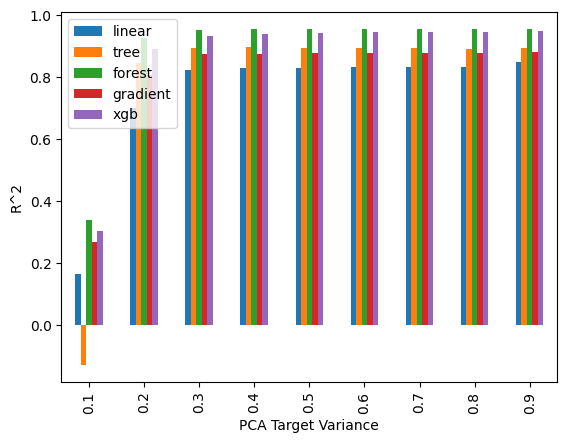

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
scores = pd.read_csv('scores.csv')
# Set index to 'variance'
scores.set_index('variance', inplace=True)
# Plot the scores (x label is "PCA Target Variance", y label is "R^2")
scores.plot(kind='bar')
plt.xlabel('PCA Target Variance')
plt.ylabel('R^2')
plt.show()